# Machine Learning for Multibody System Dynamics

## **Session 2-4:** Joint Clearance & Predictive Maintenance

Grzegorz Orzechowski & Peter Manzl

> RNN trained on sensors for the mechanism with clearance.

## Setup and imports

In [1]:
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.signal import welch

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Challenge: Joint Clearance Problems
- **Backlash & Impact Loads**  
  Clearance between mating parts (pins, bearings, joints) leads to intermittent contact, shock loads and vibrations.  
- **Uncertain Failure Modes**  
  Where will wear initiate? How severe will the impact be? Which signals best capture the onset?

![Bearing clearance](../figures/clearance-example.png)

### Modeling Using Contact Mechanics
- **Nonlinear Contact Models**  
  - **Penalty methods** or **Lagrange multipliers** to enforce gap/impact constraints  
  - Frictional contact (Coulomb stick–slip) and restitution  
- **Time-Stepping & Event Detection**  
  - Implicit/explicit integrators with collision detection  
  - Smooth transition between open-gap and contact phases

### Practical Engineering Importance
- **Precision & Accuracy**  
  Backlash degrades positioning in robots, CNC machines and linkage systems  
- **Wear & Fatigue Life**  
  Repeated impacts accelerate surface pitting and material degradation  
- **Noise, Vibration & Harshness (NVH)**  
  Clearance-induced rattle generates unwanted noise and reduces comfort

### Predictive Maintenance Aspect
- **Sensor Integration**  
  Accelerometers, eddy-current probes or strain gauges near critical joints  
- **AI-Driven Anomaly Detection**  
  Train models on “healthy” vs. “faulty” clearance signatures  
- **Early Warning & Cost Savings**  
  • Detect abnormal clearance growth before catastrophic failure  
  • Schedule targeted inspections, minimize unplanned downtime

## Data Generation: Slider-Crank Dynamics with Joint Clearance

### Mechanism Overview
- **Configuration**: Classic slider–crank  
  – Link AB (crank) of length _L₁_ pivots at A  
  – Link BC (coupler) of length _L₂_ connects crank to slider  
  – Slider C moves in a horizontal guide  
- **Clearance**:  
  – Radial gap Δ in the pin at joint A  
  – Allows intermittent “lift-off” and impact between crank and frame  

![](../figures/slider-crank-clearance.png)

### Dynamic Modeling
- **Equations of Motion**  
  – Derive Lagrange’s equations for the three-link assembly under gravity  
  – Include joint-clearance via a unilateral contact constraint at A  
- **Contact Treatment**  
  – Penalty‐based normal force _Fₙ = k·gap_ when gap ≤ 0  
  – Viscous damping _F_d = c·ẋ_ in the contact direction 

### Initial & Boundary Conditions
- **Gravity Loading**  
  – Crank-slider assembly subject to gravitational acceleration _g_  
- **Startup**  
  – Crank given initial angular velocity ω₀ at t = 0  
  – All other joints start from nominal zero clearance position  

## Preprocessing: Clearance Analysis & Its Impact on Acceleration Signals

- **Typical Clearance Analysis**  
  - **Geometric Inspection**: Measure gap Δ by coordinate‐measuring or optical methods.  
  - **Static Load Tests**: Apply preload to see “take-up” angle or displacement before contact.  
  - **Dynamic Characterization**:  
    - Sweep excitation (sinusoidal or random) to identify contact “stiffness” and damping.  
    - Use modal testing to see how the gap alters natural frequencies.

- **Effects on Acceleration Signals**  
  - **Impact Spikes**: Each “lift-off” and re-engagement at clearance produces short, high‐amplitude pulses.  
  - **High-Frequency Content**: Sharp impacts inject broadband noise and excite higher modes.  
  - **Harmonic & Sideband Generation**: Periodic impacts at crank frequency ω (and its multiples) show up as sidebands around ω in the spectrum.  
  - **RMS & Kurtosis Increase**: Overall vibration energy and signal “peakedness” rise as clearance grows—key features for anomaly detection.  

### Data loading from .npz files

The following data are stored for each 1s sequence:
- `pos`: Generalized positions,
- `vel`: Generalized velocities,
- `acc`: Generalized accelerations,
- `acc1`: Accelerometer values x,
- `acc2`: Accelerometer values y,
- `t`: Time vector,
- `label`: Label indicating if the model contains clearance or not. 

In [2]:
# Example: use only 'vel' and 'acc' with sequence length 100 and stride 50
seq_length = 100 
stride = 50

# used_vars = ['vel', 'acc'] # works well on this
used_vars = ['acc1', 'acc2']

sequences = []
labels = []

for path in glob.glob("../data/*.npz"):
    data = np.load(path)
    arrays = [data[var] for var in used_vars]
    combined = np.column_stack(arrays)
    label = int(data['label'])

    T = combined.shape[0]
    for start in range(0, T - seq_length + 1, stride):
        segment = combined[start:start + seq_length].T  # [features, seq_len]
        sequences.append(segment)
        labels.append(label)

X = np.array(sequences)
y = np.array(labels)

## Acceleration Signal without Clearance

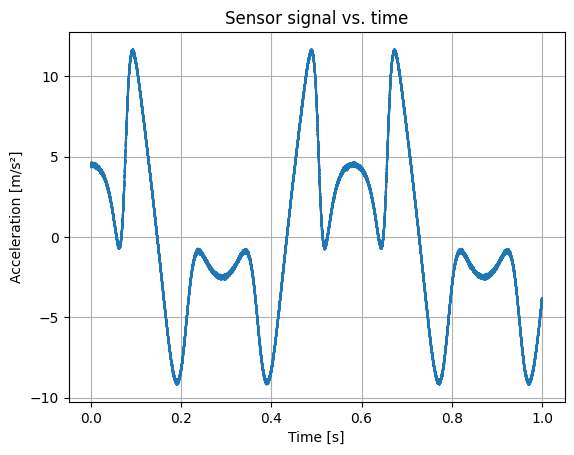

In [3]:
data = np.load("../data/data_clear_0_inivel_0.npz")
plt.plot(data['t'], data['acc1'])  # Plot first accelerometer channel over time
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s²]")
plt.title("Sensor signal vs. time")
plt.grid(True)
plt.show()

### Power Spectral Density without Clearance

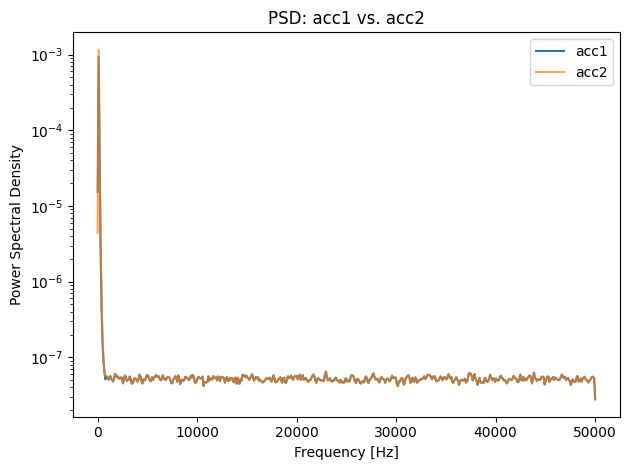

In [4]:
# 2. Extract arrays
t    = data['t']
acc1 = data['acc1']
acc2 = data['acc2']

# 3. Sampling frequency
fs = 1.0 / np.mean(np.diff(t))

# 4. Compute PSDs
f, Pxx1 = welch(acc1, fs=fs, nperseg=1024)
_, Pxx2 = welch(acc2, fs=fs, nperseg=1024)

# 5. Plot PSDs
plt.figure()
plt.semilogy(f, Pxx1, label='acc1')
plt.semilogy(f, Pxx2, label='acc2', alpha=0.7)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('PSD: acc1 vs. acc2')
plt.legend()
plt.tight_layout()
plt.show()

## Acceleration Signal with Clearance

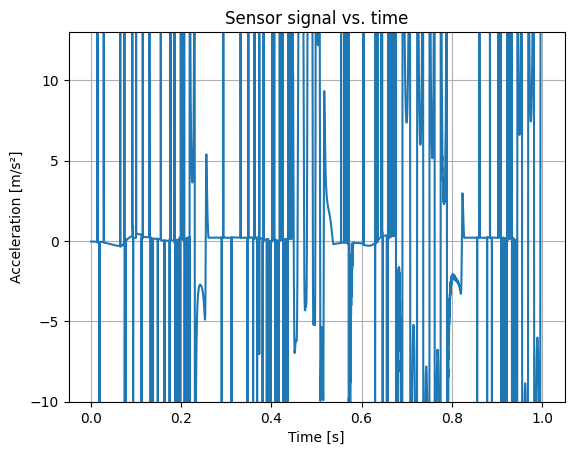

In [5]:
data = np.load("../data/data_clear_200_inivel_0.npz")
plt.plot(data['t'], data['acc1'])  # Plot first accelerometer channel over time
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s²]")
plt.title("Sensor signal vs. time")
plt.ylim([-10, 13])
plt.grid(True)
plt.show()

### Power Spectral Density without Clearance

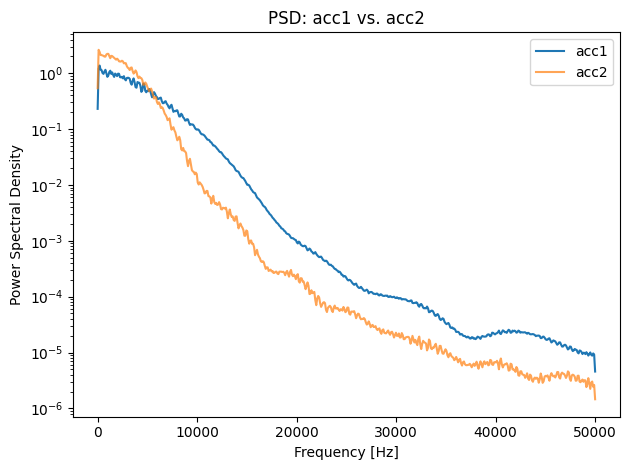

In [6]:
# 2. Extract arrays
t    = data['t']
acc1 = data['acc1']
acc2 = data['acc2']

# 3. Sampling frequency
fs = 1.0 / np.mean(np.diff(t))

# 4. Compute PSDs
f, Pxx1 = welch(acc1, fs=fs, nperseg=1024)
_, Pxx2 = welch(acc2, fs=fs, nperseg=1024)

# 5. Plot PSDs
plt.figure()
plt.semilogy(f, Pxx1, label='acc1')
plt.semilogy(f, Pxx2, label='acc2', alpha=0.7)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('PSD: acc1 vs. acc2')
plt.legend()
plt.tight_layout()
plt.show()

## Preprocessing cont.: Shuffle and split the dataset

We’ll shuffle the data and split it into training, validation, and test sets with ratios 70/15/15 — just like in your MATLAB code.



In [7]:
# Shuffle and split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)
# 0.1765 ≈ 15% / 85% to keep the right ratio

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 5596, Val: 1200, Test: 1200


## Define PyTorch Dataset and DataLoaders

This custom dataset wraps your sequence data and labels so you can use it with PyTorch’s DataLoader.

In [8]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, features, seq_len]
        self.y = torch.tensor(y, dtype=torch.long)     # [N]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model Selection: Define the GRU model in PyTorch

Let’s define the GRU model. Based on your MATLAB setup:
	•	Input size = 47
	•	GRU hidden units = 32
	•	Output = 2 classes (binary classification)

[RNN vs LSTM vs GRU vs Transformers](https://www.geeksforgeeks.org/deep-learning/rnn-vs-lstm-vs-gru-vs-transformers/)

[Wiki on GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

In [9]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size=47, hidden_size=32, num_classes=2):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # x shape: [batch_size, features, seq_len] ➜ transpose to [batch_size, seq_len, features]
        x = x.permute(0, 2, 1)
        _, h_n = self.gru(x)  # h_n: [1, batch_size, hidden_size]
        out = self.fc(h_n.squeeze(0))  # [batch_size, num_classes]
        return out

## Setup training utilities

This defines the model, loss function, optimizer, and device.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = GRUClassifier(input_size=X_train.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


## Model Training: the GRU with validation

We’ll track training and validation loss, and optionally stop early if validation doesn’t improve for several epochs.

In [11]:
num_epochs = 40
best_val_loss = float('inf')
patience = 7
wait = 0

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")  # save best model
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/40 | Train Loss: 0.4287 | Val Loss: 0.2712
Epoch 2/40 | Train Loss: 0.2025 | Val Loss: 0.1686
Epoch 3/40 | Train Loss: 0.1426 | Val Loss: 0.1329
Epoch 4/40 | Train Loss: 0.1173 | Val Loss: 0.1115
Epoch 5/40 | Train Loss: 0.1003 | Val Loss: 0.1004
Epoch 6/40 | Train Loss: 0.0919 | Val Loss: 0.0876
Epoch 7/40 | Train Loss: 0.0860 | Val Loss: 0.0808
Epoch 8/40 | Train Loss: 0.0735 | Val Loss: 0.0607
Epoch 9/40 | Train Loss: 0.0711 | Val Loss: 0.0616
Epoch 10/40 | Train Loss: 0.0618 | Val Loss: 0.0561
Epoch 11/40 | Train Loss: 0.0599 | Val Loss: 0.0768
Epoch 12/40 | Train Loss: 0.0739 | Val Loss: 0.2367
Epoch 13/40 | Train Loss: 0.0885 | Val Loss: 0.0640
Epoch 14/40 | Train Loss: 0.0554 | Val Loss: 0.0527
Epoch 15/40 | Train Loss: 0.0484 | Val Loss: 0.0485
Epoch 16/40 | Train Loss: 0.0515 | Val Loss: 0.0441
Epoch 17/40 | Train Loss: 0.0450 | Val Loss: 0.0423
Epoch 18/40 | Train Loss: 0.0718 | Val Loss: 0.0424
Epoch 19/40 | Train Loss: 0.0767 | Val Loss: 0.0620
Epoch 20/40 | Train L

## Evaluation and testing: Plot training history

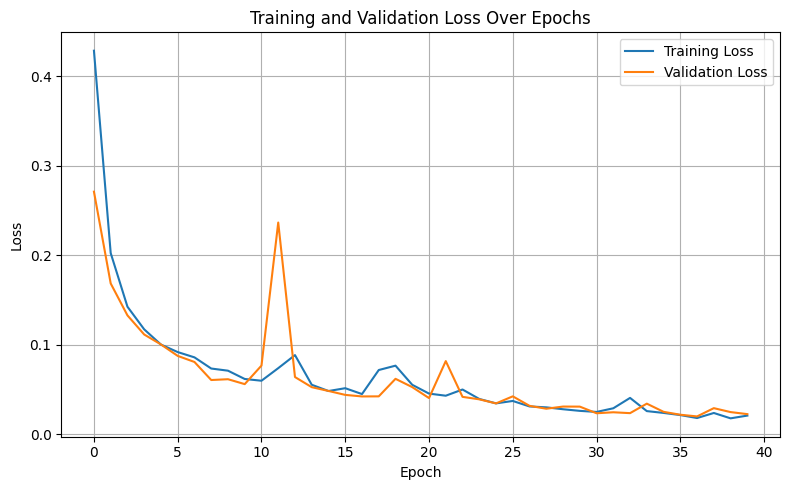

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Load best model and evaluate on test set

We’ll:
- Load the best model
- Run predictions
- Compute accuracy
- Generate a confusion matrix

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# 1) Load model and collect predictions
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        targets = y_batch.numpy()
        all_preds.extend(preds)
        all_targets.extend(targets)

## Get accuracy measure and confusion matrix

In [14]:
# 2) Compute accuracy
test_acc = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# 3) Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)
labels = ['No Clearance', 'Has Clearance']

Test Accuracy: 99.67%


### Helper to plot confusion matrix

In [15]:
def plot_confusion_matrix(cm, labels, normalize=False, cmap=plt.cm.Blues):
    """
    cm: 2D array from sklearn.metrics.confusion_matrix
    labels: list of class names
    normalize: whether to row-normalize
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(im, ax=ax)

    # Set tick labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    # Labeling
    title = 'Normalized Confusion Matrix' if normalize else 'Confusion Matrix (counts)'
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return fig, ax

## Plot results

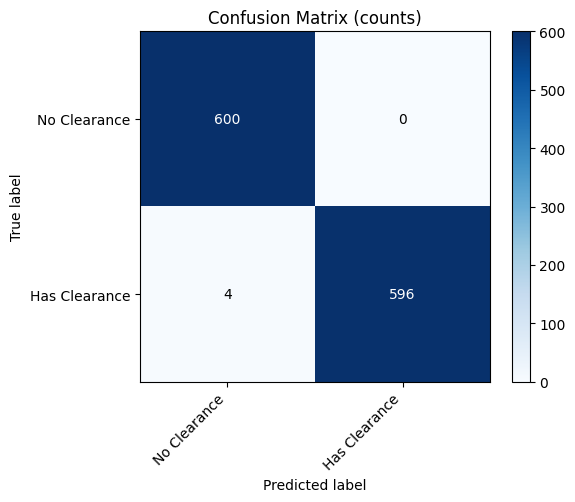

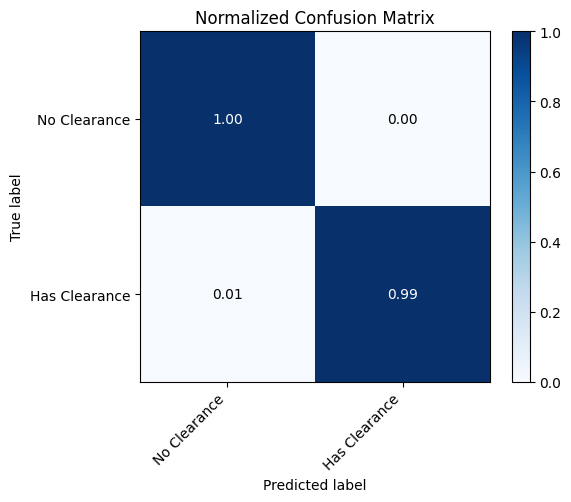

In [16]:
# Plot raw counts
plot_confusion_matrix(cm, labels, normalize=False)
plt.show()

# Plot normalized
plot_confusion_matrix(cm, labels, normalize=True)
plt.show()

### That's all about supervised learning

Let's take a break and continue afterwards with [Reinforcement Learning](../Session-3-ReinforcementLearning/3-1_Introduction.ipynb)